Same as mantid_waterIN5_fit3 using improved Python notation for definining fit models, which has been available since Mantid release 3.12 (should check). 

Also since 31st May 2018 it is possible within a Python session to define/import new fit function and use them. Previously such would only be available within the Mantid C++ framework but not exposed to out to Python.

For this notebook to work do:

* (not required in version below yet: Install a night build of Mantid dating from 31st May 2018 onwards or a Mantid release released after this date)

* On Windows, from a command prompt <br>
  `type c:/MantidInstall/bin/mantidpython.bat notebook`

* on MacOS, from a terminal type <br>
  `Applications/MantidPlot.app/Contents/MacOS/mantidpython notebook`
  
* **TODO** on Linux

For more info on working with IPython/Jupyter and Mantid see also: http://www.mantidproject.org/Using_IPython_Notebook

**Setup Mantid**

In [12]:
import sys
import os

#Tell python where Mantid is installed.
#The official packages put this information in an environment variable called "MANTIDPATH"
sys.path.append(os.environ['MANTIDPATH'])
# for example, on Mac, it is '/Applications/MantidPlot.app/Contents/MacOS'

#We can now import Mantid's Python API
from mantid.simpleapi import *

** Setup QENS models library**

In [2]:
import QENSmodels

**Setup matplotlib, numpy etc**

In [11]:
import numpy as np
from scipy.constants import pi

#Some magic to tell matplotlib how to behave in IPython Notebook
%matplotlib inline

import matplotlib.pyplot as plt

### Load data

In [13]:
# Path to where the data for the examples are (/QENSmodels/examples/data)
path_to_data = os.path.join(os.getcwd(), 'data/')

# experimental data
ws_5Aini = LoadLamp(path_to_data+'H2O_293K_5A.hdf')

# vanadium
res_5Aini = LoadLamp(path_to_data+'V_273K_5A.hdf')

hw_5A = ws_5Aini.readX(0)

idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
index_4_trunc_5A = idx_5A[0].tolist()

print(ws_5Aini.getNumberHistograms(), ws_5Aini.blocksize())
print(res_5Aini.getNumberHistograms(), res_5Aini.blocksize())

(17, 160)
(17, 160)


In [14]:
# Force resolution function to have unit area
norm_res_5A = CloneWorkspace(res_5Aini)

for i in range(res_5Aini.getNumberHistograms()):
    area = Integration(res_5Aini, StartWorkspaceIndex=i, EndWorkspaceIndex=i)
    y_norm = norm_res_5A.dataY(i)
    y_norm /= area.readY(0)[0]

# Fit range -1meV < energy < 1 meV
x = hw_5A[index_4_trunc_5A]

# Apply truncation to data
ws_5A = CropWorkspace(ws_5Aini, XMin=-1, Xmax=1)

# Same procedure for normalised resolution
res_5A = CropWorkspace(norm_res_5A,  XMin=-1, XMax=1)

# Extract values of q to be used in parameters of fitting models
q_5A = ws_5A.getAxis(1).extractValues()

# Remove invalid data (negative errors)
for ii in range(len(q_5A)):
    yy = ws_5A.dataY(ii)
    err = ws_5A.dataE(ii)
    for jj in range(ws_5A.blocksize()):
        if err[jj] <= 0:
            yy[jj] = 0
            err[jj] = 0

### Definition of fitting model
References in Mantid:
- https://www.mantidproject.org/Python_Function_Attributes

- http://docs.mantidproject.org/nightly/api/python/mantid/api/IFunction1D.html?highlight=ifunction1d#mantid.api.IFunction1D.fixParameter


In [15]:
class MyModel(IFunction1D):
    """ Definition of model"""
    def init(self):
        self.declareAttribute("Q", 1.0)
        self.declareParameter("scale_factor", 20)
        self.declareParameter("centre_lorentzian", 0.) 
        self.declareParameter("hwhm", 1.)
        self.declareParameter("centre_rot", 0.)
        self.declareParameter("radius", 0.98) 
        self.declareParameter("DR", 2.)
        
    def setAttributeValue(self, name, value):
        if name == "Q":
            self._Q = value
            
    def function1D(self, w):
        # Access current values during the fit
        Q = self.getAttributeValue("Q")
        scale_factor = self.getParameterValue("scale_factor")
        centre_lorentzian = self.getParameterValue("centre_lorentzian")
        hwhm = self.getParameterValue("hwhm")
        centre_rot = self.getParameterValue("centre_rot")
        radius = self.getParameterValue("radius")
        DR = self.getParameterValue("DR")
        
        my_model = QENSmodels.lorentzian(w, scale_factor, centre_lorentzian, hwhm) + QENSmodels.sqwIsotropicRotationalDiffusion(w, Q, scale_factor, centre_rot, radius, DR)

        return my_model

FunctionFactory.subscribe(MyModel)

my_model = MyModel()

# Resolution
res_func = Resolution(Workspace='res_5A', WorkspaceIndex=0)

# Full model = user defined model convoluted with resolution
my_func = Convolution(res_func, my_model)

# Check if user defined model is equal to the sum of related QENS models
w0=2.
Q0=0.5
scale_factor0=20.
centre_lorentzian0=0.0
hwhm0=0.01
centre_rot0=0.0
radius0=0.98
DR0=2.

print('Number of attributes in model:', my_model.nAttributes())
print('Number of parameters in model:', my_model.nParams())
my_model.setAttributeValue('Q', Q0)
print(my_model(w0, scale_factor0, centre_lorentzian0, hwhm0, centre_rot0, radius0, DR0))

print(QENSmodels.lorentzian(w0, scale_factor0, centre_lorentzian0, hwhm0) + QENSmodels.sqwIsotropicRotationalDiffusion(w0, Q0, scale_factor0, centre_rot0, radius0, DR0))

single_model_template="""(composite=Convolution,FixResolution=true,NumDeriv=true;\
name=Resolution,Workspace=res_5A,WorkspaceIndex=_WI_;\
name=MyModel,Q=_Q_,scale_factor=20,centre_lorentzian=0,hwhm=0.01,centre_rot=0,radius=0.98,DR=2.)""".format(pi=pi)


('Number of attributes in model:', 1)
('Number of parameters in model:', 6)
0.113664085402
[ 0.11366409]


In [17]:
# Now create the string representation of the global model (all spectra, all Q-values):
global_model="composite=MultiDomainFunction,NumDeriv=true;"
wi = 0
for Q in q_5A:
    single_model = single_model_template.replace("_Q_", str(Q))  # insert Q-value
    single_model = single_model.replace("_WI_", str(wi))  # workspace index
    global_model += "(composite=CompositeFunction,NumDeriv=true,$domains=i;{0});\n".format(single_model)
    wi+=1
# The Radius, Tau, and D are the same for all spectra, thus tie them:
ties = ['='.join(["f{0}.f0.f1.radius".format(wi) for wi in reversed(range(len(q_5A)))]),
        '='.join(["f{0}.f0.f1.DR".format(wi) for wi in reversed(range(len(q_5A)))])]
global_model += "ties=("+','.join(ties)+')'  # tie radius and D

In [18]:
# Now relate each domain(i.e. spectrum) to each single model
domain_model = dict()
for wi in range(len(q_5A)):
    if wi == 0:
        domain_model.update({"InputWorkspace": ws_5A.name(), "WorkspaceIndex": str(wi),
            "StartX": "-1", "EndX": "1"})
    else:
        domain_model.update({"InputWorkspace_"+str(wi): ws_5A.name(), "WorkspaceIndex_"+str(wi): str(wi),
            "StartX_"+str(wi): "-1", "EndX_"+str(wi): "1"})

In [19]:
# Invoke the Fit algorithm using global_model and domain_model:
output_workspace = "glofit_"+ws_5A.name()
fit_output = Fit(Function=global_model, Output=output_workspace, CreateOutput=True, MaxIterations=10, **domain_model)

In [22]:
## Print some results
fitWorkspace = fit_output.OutputWorkspace
paramTable = fit_output.OutputParameters

## print results for refined parameters
print('Table of refined parameters: Name Value Error')

for i in range(paramTable.rowCount()):
    print(paramTable.column(0)[i],
          paramTable.column(1)[i],
          paramTable.column(2)[i])

Table of refined parameters: Name Value Error
('f0.f0.f1.scale_factor', 14.301670523931744, 104.2825484878647)
('f0.f0.f1.centre_lorentzian', 0.0011356501252893, 10947.967803176223)
('f0.f0.f1.hwhm', 0.06541894552279191, 10121.54760014443)
('f0.f0.f1.centre_rot', 0.0, 0.0)
('f0.f0.f1.radius', 3.098224897892666, 671.1645181465303)
('f0.f0.f1.DR', -9048.279272927542, 1.7781090705681235e-05)
('f1.f0.f1.scale_factor', 16.00333202232436, 95.52062943066514)
('f1.f0.f1.centre_lorentzian', 0.0022141718908319104, 10281.208323721416)
('f1.f0.f1.hwhm', 0.08099201556708138, 9462.326777321843)
('f1.f0.f1.centre_rot', 0.0, 0.0)
('f1.f0.f1.radius', 3.098224897892666, 0.0)
('f1.f0.f1.DR', -9048.279272927542, 0.0)
('f2.f0.f1.scale_factor', 20.106964553469584, 76.36129788720491)
('f2.f0.f1.centre_lorentzian', 0.0023469814594422513, 13165.289493440005)
('f2.f0.f1.hwhm', 0.07502434295786534, 12337.000661831473)
('f2.f0.f1.centre_rot', 76208.6774906795, 1.6939231814989095e-07)
('f2.f0.f1.radius', 3.0982248

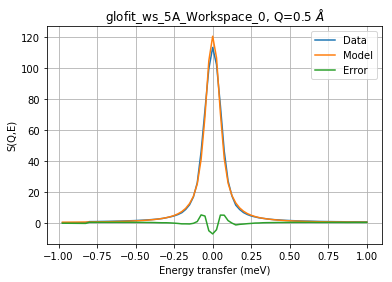

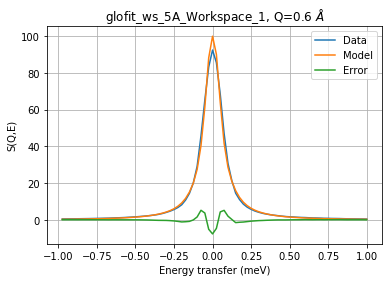

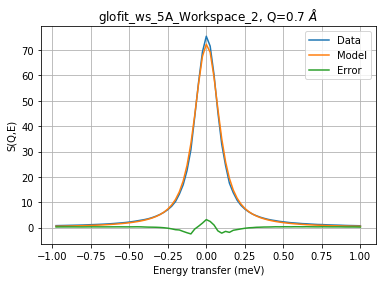

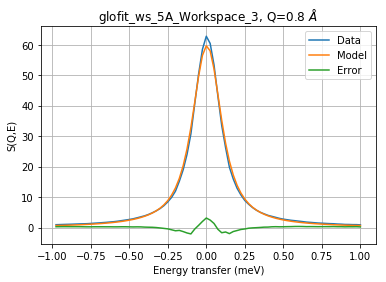

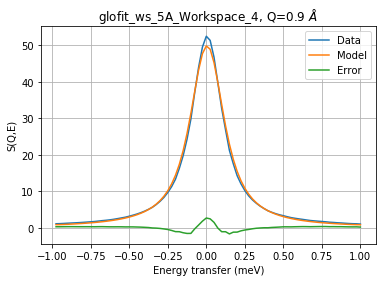

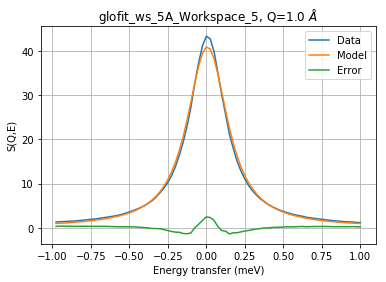

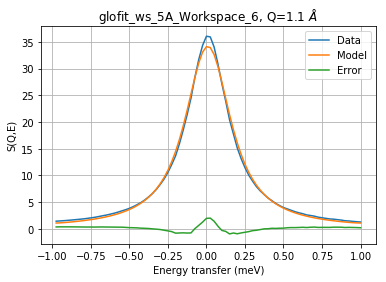

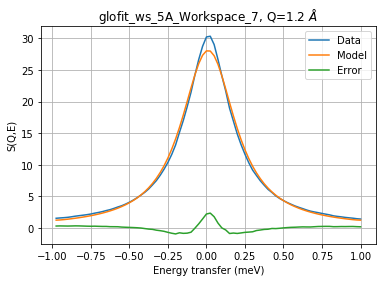

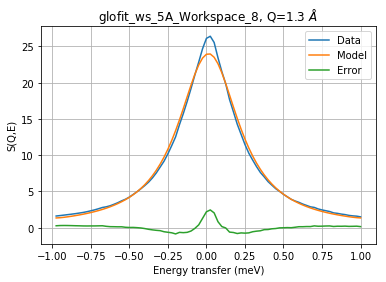

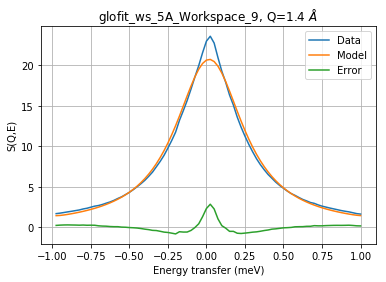

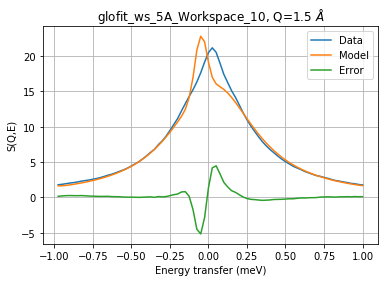

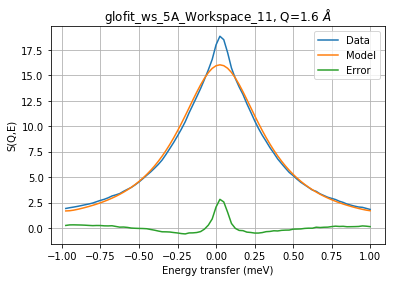

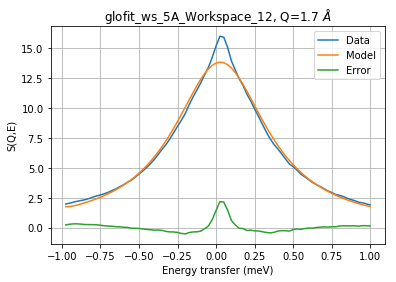

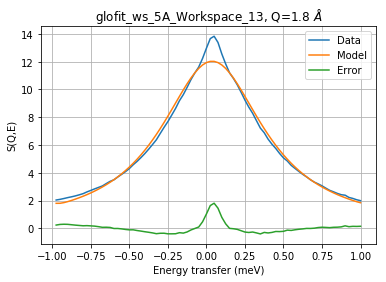

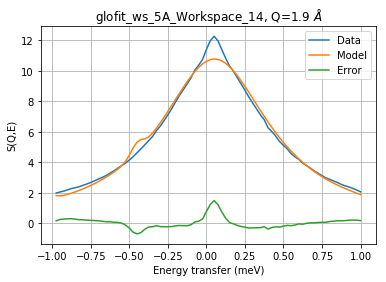

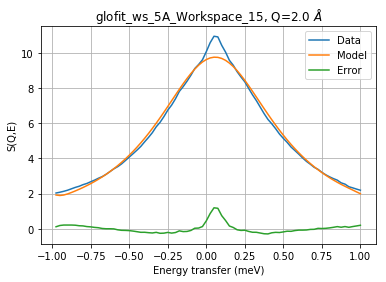

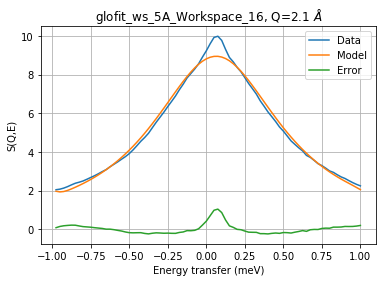

In [23]:
# Plot results: one plot / spectrum showing experimental, fitted data
# and difference

for indx, item in enumerate(fitWorkspace.getNames()):
    x = mtd[item].readX(0)
    plt.plot(x, mtd[item].readY(0), label="Data")
    plt.plot(x, mtd[item].readY(1), label="Model")
    plt.plot(x, mtd[item].readY(2), label="Error")
    plt.xlabel('Energy transfer (meV)')
    plt.ylabel('S(Q,E)')
    plt.legend()
    plt.grid()
    plt.title(item + r", Q={:.1f} $\AA$".format(q_5A[indx]))
    plt.show()